<a href="https://colab.research.google.com/github/jini-ninii/ML_labs/blob/main/lab5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5.2

По итоговому датасету:

1. Преобразовать текстовые данные (очистка + токенизация + нормализация).
2. Обучить модель **Word2Vec** на текстах.
3. Заполнить пропуски в числовых признаках через **SimpleImputer**.
4. Выбрать алгоритм **кластеризации** и построить кластеры.
5. Построить модель для **предсказания кластера** (supervised) с подбором гиперпараметров через **GridSearchCV**.


In [1]:
!pip install pymorphy3 gensim scikit-learn nltk # бибилотеки с которыми будем работать

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 11.0 MB/s eta 0:00:00


In [2]:
# Базовые импорты
import pandas as pd
import numpy as np
import sqlite3


In [5]:
# Подключаемся к файлу базы данных
conn = sqlite3.connect("articles_nsk.db")

# Загружаем всё из таблицы
df = pd.read_sql_query("SELECT * FROM articles;", conn)
conn.close()



In [6]:
df.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,c577ac86-6274-4b2a-9564-d87e2cff3ab6,Победителей чемпионата «Абилимпикс» торжествен...,По словам участников ─ это очень важный этап в...,http://www.nsktv.ru/news/obshchestvo/pobeditel...,"18 декабря 2025, 13:45",0,2025-12-19T00:32:24.298428+00:00,0
1,4af54903-66d5-4f4b-b914-7ac6a0a314be,Новосибирцы могут пройти диспансеризацию всей ...,Более 920 тысяч жителей Новосибирской области ...,http://www.nsktv.ru/news/medicine/novosibirtsy...,"18 декабря 2025, 14:38",0,2025-12-19T00:32:24.389981+00:00,0
2,7ffbc3c2-02fe-4003-93fd-e9a4137d6af9,Декабрьский выпуск «Сибирских сказок» посвятил...,Проект стартовал в 2018 году для поддержки юны...,http://www.nsktv.ru/news/obshchestvo/dekabrski...,"18 декабря 2025, 16:02",0,2025-12-19T00:32:24.474396+00:00,0
3,1fc5c65e-54b1-4554-a49a-e23feae55023,У новосибирцев осталось две недели заключить в...,В пункте отбора на военную службу по контракту...,http://www.nsktv.ru/news/army/u_novosibirtsev_...,"18 декабря 2025, 13:17",0,2025-12-19T00:32:24.485535+00:00,0
4,4984bfa3-8ec9-4d5a-b6c6-f39ffd2db831,Новосибирцы стали всё чаще выбирать улыбку и «...,Платежи улыбкой не требуют пластиковой карты и...,http://www.nsktv.ru/news/obshchestvo/novosibir...,"18 декабря 2025, 14:21",0,2025-12-19T00:32:24.490141+00:00,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   guid            5034 non-null   object
 1   title           5034 non-null   object
 2   description     5034 non-null   object
 3   url             5034 non-null   object
 4   published_at    5034 non-null   object
 5   comments_count  5034 non-null   int64 
 6   created_at_utc  5034 non-null   object
 7   rating          5034 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 314.8+ KB


## Предобработка

Чистим текст от мусора, приводим к начальной форме и удаляем стоп-слова.

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer

# Скачиваем стоп-слова
nltk.download("stopwords")

morph = MorphAnalyzer()
STOP_RU = set(stopwords.words("russian"))
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)

def preprocess_text(text: str):

    if not isinstance(text, str):
        return []

    # Приводим к нижнему регистру
    text = text.lower()

    # Оставляем только буквы (удаляем цифры и знаки препинания)
    text = re.sub(r'[^а-яёa-z]', ' ', text)

    # Разбиваем на слова (токены)
    tokens = text.split()

    # Лемматизация и удаление стоп-слов
    clean_tokens = []
    for token in tokens:
        # Удаляем короткие слова (меньше 3 букв) и стоп-слова
        if token not in STOP_RU and len(token) > 2:
            # Получаем начальную форму слова
            lemma = morph.parse(token)[0].normal_form
            clean_tokens.append(lemma)

    return clean_tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Применяем функцию к колонке description (основной текст новости).

In [9]:
df['clean_text'] = df['description'].apply(preprocess_text)
df[['description', 'clean_text']].head()

,description,clean_text
0,По словам участников ─ это очень важный этап в...,"[слово, участник, это, очень, важный, этап, жи..."
1,Более 920 тысяч жителей Новосибирской области ...,"[тысяча, житель, новосибирский, область, пройт..."
2,Проект стартовал в 2018 году для поддержки юны...,"[проект, стартовать, год, поддержка, юный, авт..."
3,В пункте отбора на военную службу по контракту...,"[пункт, отбор, военный, служба, контракт, ново..."
4,Платежи улыбкой не требуют пластиковой карты и...,"[платёж, улыбка, требовать, пластиковый, карта..."


## Обучение модели

Теперь превращаем слова в цифры (векторы).

In [10]:
from gensim.models import Word2Vec
import numpy as np

w2v = Word2Vec(
    sentences=df['clean_text'],
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10,
)

def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_vectors = np.vstack([doc_vector(t, w2v) for t in df['clean_text']])
doc_vectors.shape


(5034, 100)

Посмотрим, какие слова похожи на "наука".

In [11]:
print(f"\nПохожие слова для 'наука':")
for word, score in w2v.wv.most_similar("наука", topn=10):
  print(f"  {word:15s} {score:.3f}")


Похожие слова для 'наука':
  доцент          0.700
  пасман          0.694
  инновация       0.680
  урология        0.676
  эндоскопический 0.674
  доктор          0.666
  профессор       0.656
  исследователь   0.652
  аддитивный      0.649
  индустрия       0.648


## Обработка числовых признаков

Числовые признаки (comments_count, rating) равны 0 и не несут информации. Мы их просто игнорируем. В качестве признаков используем только векторы текста.

In [12]:
X_features = doc_vectors

## Кластеризация


In [13]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Снижаем размерность до 2 компонент для кластеризации и визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

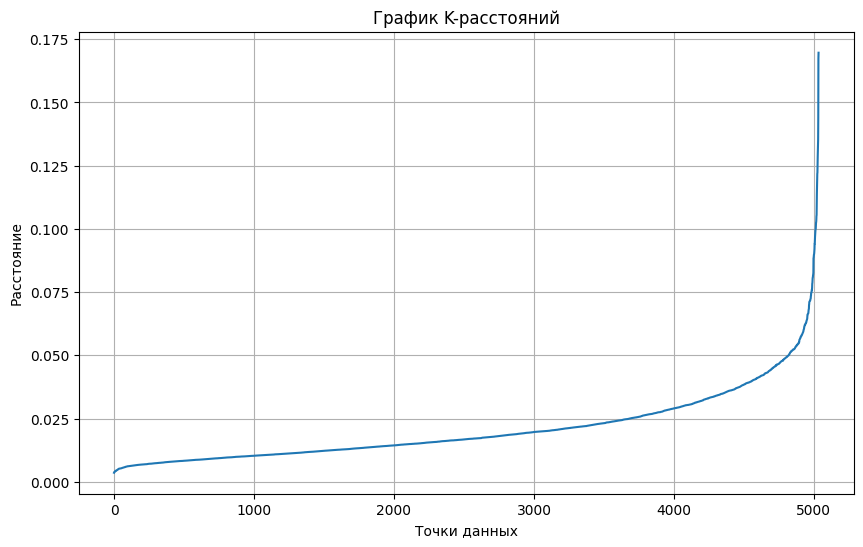

In [15]:
# Выбираем число соседей
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_pca)

# Считаем расстояния до k ближайших соседей
distances, indices = nbrs.kneighbors(X_pca)

# Берем расстояние до k-го соседа (последний столбец) и сортируем
distance_desc = sorted(distances[:, k-1])

# Рисуем график
plt.figure(figsize=(10, 6))
plt.plot(distance_desc)
plt.title('График K-расстояний')
plt.ylabel('Расстояние')
plt.xlabel('Точки данных')
plt.grid(True)
plt.show()

In [19]:
# Точка сгиба примерно 0.025
dbscan = DBSCAN(eps=0.025, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

df['cluster'] = clusters

np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([ 969, 2618,    6,   23,   16,   31,   28,  574,  225,   13,    9,
          11,   18,    5,   23,    6,   19,   21,   59,    5,    5,   21,
          17,   22,    7,   10,    8,    6,   46,   15,    6,   15,    6,
           8,   12,    5,    5,    3,    5,    7,    7,    6,    4,   11,
           5,    5,    8,    4,    6,    4,   12,    5,    6,    5,    5,
           5,    6,    5,    5,    7,    5]))

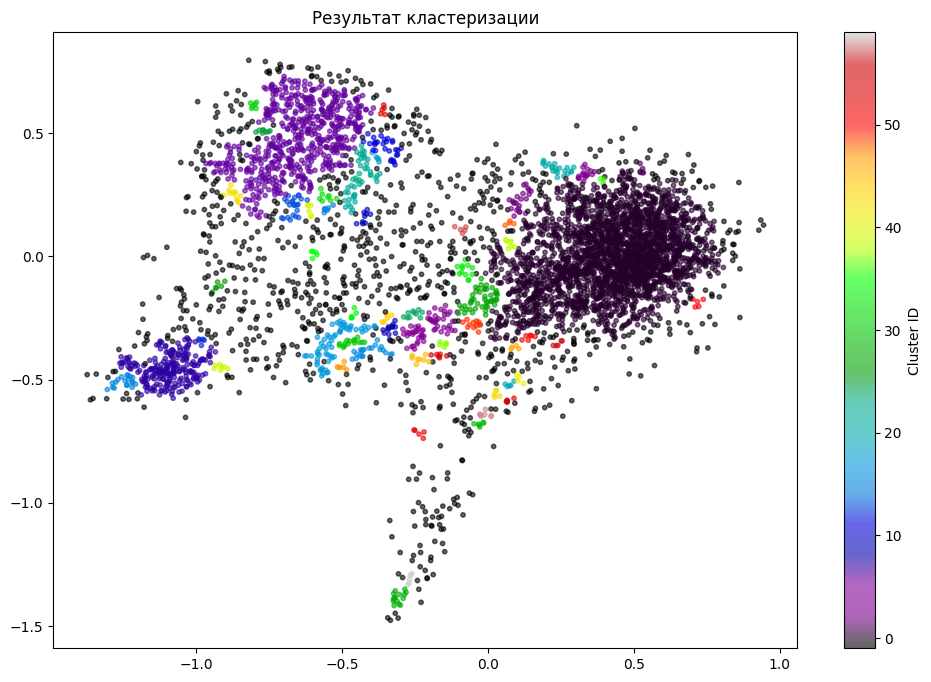

In [20]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='nipy_spectral', s=10, alpha=0.6)
plt.title('Результат кластеризации')
plt.colorbar(scatter, label='Cluster ID')
plt.show()

## Предсказать кластеры методом DecisionTree

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Мы берем только те статьи, которые попали в реальные кластеры (не шум -1)
mask = df['cluster'] != -1
X = X_features[mask]            # Фильтруем признаки
y = df.loc[mask, "cluster"]     # Фильтруем ответы

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"],
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
)

grid_dt.fit(X_train, y_train)

print("Лучшие параметры:", grid_dt.best_params_)
print("Лучший CV accuracy:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Лучшие параметры: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучший CV accuracy: 0.8432379038413371
Test accuracy: 0.8524590163934426
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       786
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         5
           4       0.50      0.11      0.18         9
           5       0.20      0.75      0.32         8
           6       0.81      0.99      0.89       172
           7       0.91      0.91      0.91        68
           8       0.00      0.00      0.00         4
           9       0.10      0.33      0.15         3
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         7
          

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Предсказать кластеры методом KNN

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Снова берем чистые данные (без шума -1)
mask = df['cluster'] != -1
X = X_features[mask]
y = df.loc[mask, "cluster"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [3, 5, 10, 15],
    "weights": ["uniform", "distance"],
    "metric": ["cosine"],
}

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший CV accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}
Лучший CV accuracy: 0.8710027136418675
Test accuracy: 0.8647540983606558
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       786
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         7
           3       0.20      0.20      0.20         5
           4       0.50      0.11      0.18         9
           5       0.33      0.50      0.40         8
           6       0.82      0.99      0.89       172
           7       0.87      0.90      0.88        68
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         7
          14       0.00      0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Обе обученные модели показали высокую точность на тестовой выборке. Это свидетельствует о том, что признаки, сформированные на этапе векторизации, и кластеры, выделенные алгоритмом DBSCAN (после фильтрации шума), имеют четкую структуру и хорошо линейно разделимы.

classification_report показывает сильный дисбаланс классов: доминирующая тема (кластер 0) распознается идеально. Также модели хорошо справляются со средними по размеру темами (например, кластер 2 с f1-score 0.96). Ошибки наблюдаются только на минорных кластерах, представленных в тестовой выборке единичными примерами, что является ожидаемым поведением при таком распределении данных.